#Project Overview
We are building an NLP model to analyze sentiment in tweets about Apple and Google products. The dataset includes human-labeled sentiment ratings for tweets. Our goal is to create a model that can classify tweets as positive, negative, or neutral based on their content.

#1. Business Understanding
Stakeholder: Apple company wants to understand customer sentiment from Twitter.

Business Problem: Our company needs to build an NLP Model to monitor brand perception/sentiments and respond to customer feedback efficiently.

Goal: To Build a model that classifies tweets as positive, negative, or neutral to help automate sentiment analysis.

#2. Data Understanding
##Loading the dataset and exploring its structure

In [59]:
#Importing essential Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Natural language processing libraries
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer,word_tokenize
import re
from nltk import FreqDist
from wordcloud import WordCloud
#scikit-learn
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import label_binarize
#Evaluation metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_curve,auc,r2_score,f1_score,roc_auc_score,ConfusionMatrixDisplay
#imbalanced-learn
from imblearn.pipeline import Pipeline  # Use imbalanced-learn's Pipeline
from imblearn.over_sampling import SMOTE

In [60]:
# Loading the dataset
file_path = "Apple-Twitter-Sentiment-DFE.csv"
df = pd.read_csv(file_path, encoding="latin1")

# Displaying the first few rows
df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [61]:
# Checking the dataset info
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


We evaluated the columns from the dataset and the most relevant columns were the text and sentiment column that were used in our analysis.

In [5]:
#Extracts the text and sentiment column and previews the first five rows
df = df[['text','sentiment']]
df.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3


In [6]:
#checks the number of records and features
df.shape
print(f'This dataset contains {df.shape[0]} rows')
print(f'This dataset contains {df.shape[1]} columns')

This dataset contains 3886 rows
This dataset contains 2 columns


In [7]:
#info of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3886 non-null   object
 1   sentiment  3886 non-null   object
dtypes: object(2)
memory usage: 60.8+ KB


In [8]:
#confirming there are no null values
df.isnull().sum()

,0
text,0
sentiment,0


In [10]:
#checking and removing duplicates
df[df.duplicated()]

,text,sentiment
32,RT @thehill: Justice Department cites 18th cen...,3
34,RT @thehill: Justice Department cites 18th cen...,3
38,RT @thehill: Justice Department cites 18th cen...,3
42,RT @thehill: Justice Department cites 18th cen...,3
45,RT @thehill: Justice Department cites 18th cen...,3
...,...,...
3846,RT @TeamCavuto: Protesters stage #DieIn protes...,3
3852,RT @TeamCavuto: Protesters stage #DieIn protes...,3
3855,RT @Ecofantasy: Thinking of upgrading to #Yose...,1
3878,RT @shannonmmiller: Love the @Apple is support...,5


From the evaluation above we have identified there are no null values but duplicates are present

In [9]:
#Summary of our dataset
df.describe()

,text,sentiment
count,3886,3886
unique,3219,4
top,"RT @OneRepublic: Studio at 45,000 ft. One out...",3
freq,304,2162


From the summary of our dataset, one tweet was duplicated severally.

#3. Data Preparation
Data cleaning

We handled duplicate values by dropping them

In [11]:
#Dropping the above duplicates
df.drop_duplicates(inplace=True)

In [12]:
#Checking Sentiment labels
df['sentiment'].value_counts()

,count
sentiment,
3,1681
1,1102
5,379
not_relevant,81


In [13]:
#Dropping the ‘not_relevant’ label and confirm it has been removed
#drop the not_relevant label
data =df.query('~(sentiment=="not_relevant")') #data = df.query('sentiment !="not_relevant"')
#confirm sentiment 'not_relevant' has been removed
data['sentiment'].value_counts()

,count
sentiment,
3,1681
1,1102
5,379


We dropped non-relevant labels then we summed the total counts of the positive, negative and neutral sentiments then we represented them in terms of percentage.

Negative - 34.8%

Neutral - 53.1%

Positive - 11.9%

In [14]:
#Convert Sentiment column to int
data['sentiment'] = data['sentiment'].astype(int)
#confirm removal using info method
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3243 entries, 0 to 3884
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3243 non-null   object
 1   sentiment  3243 non-null   object
dtypes: object(2)
memory usage: 76.0+ KB


<ipython-input-14-5e215b62b5ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['sentiment'].astype(int)


Preprocess text

This process involves removing stopwords, punctuation marks, hashtags, urls and lemmatization.

In [15]:
import nltk

# Download necessary NLTK resources
nltk.download('punkt')  # Downloads the 'punkt' resource
nltk.download('stopwords')  # Downloads the 'stopwords' resource
nltk.download('punkt_tab') # Downloads the 'punkt_tab' resource for sentence tokenization
nltk.download('wordnet') # Downloads the 'wordnet' resource for lemmatization
def clean_text(text):
    stopword_list = stopwords.words('english')
    stopword_list += string.punctuation
    lemmatizer = WordNetLemmatizer()

    #remove hyperlinks,usernames,words with 1 character,hashtags and their values
    text =re.sub(r"https?:[^\s]+|@[\S]+|\b\w\b|\#\w+|\.\.+", "", text)

    # Tokenize the text
    text = word_tokenize(text)

    # Lowercase the text and remove stopwords
    text = [word.lower() for word in text if word.lower() not in stopword_list]

     #lemmatize
    text = [lemmatizer.lemmatize(word)for word in text]

    # join processed text as a single string
    text = ' '.join(text)
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


After preprocessing, we added a new column of the cleaned text

In [16]:
data['cleaned_text'] = data['text'].apply(clean_text)
### confirm data procesed
data[['text','cleaned_text']].head()

<ipython-input-16-5e0a5522e1fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_text'] = data['text'].apply(clean_text)


,text,cleaned_text
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,10 best steve job email ever
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,rt aapl stock mini-flash crash today aapl
2,My cat only chews @apple cords. Such an #Apple...,cat chew cord
3,I agree with @jimcramer that the #IndividualIn...,agree trade extended today pullback good see
4,Nobody expects the Spanish Inquisition #AAPL,nobody expects spanish inquisition


###EDA
Data Visualization of Target variables

<ipython-input-17-415a34bc1a4e>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(title='Distribution of Target variables',xticklabels=['Negative','Neutral','positive']);


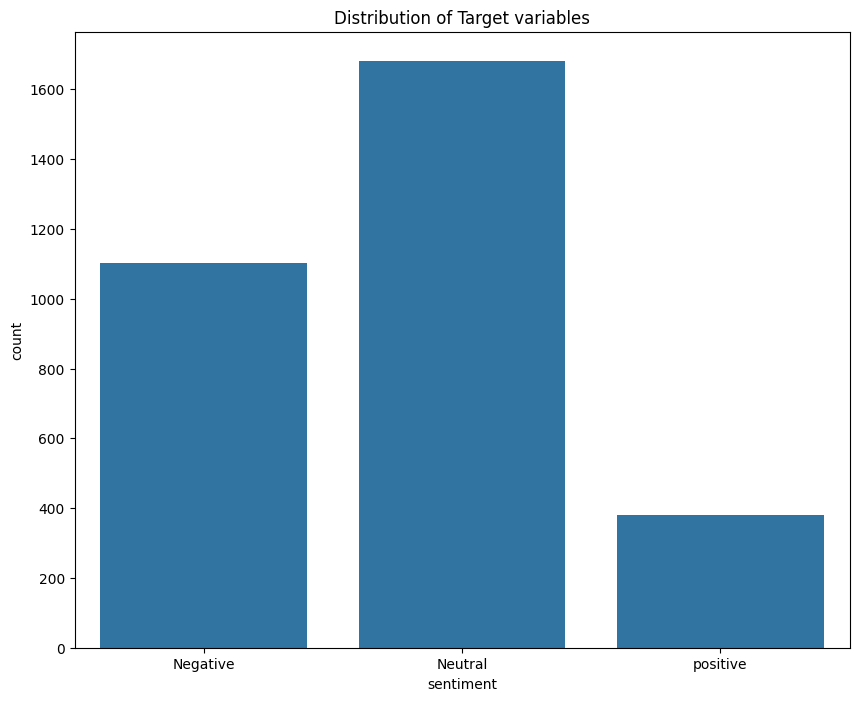

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax= sns.countplot(data = data, x='sentiment')
#using xtickslabels to label values 1 as negative,3 as neutral and 5 as positive
ax.set(title='Distribution of Target variables',xticklabels=['Negative','Neutral','positive']);

The distribution of the target variables looks imbalanced, whereby the neutral sentiment takes more than 50 % of the values and positive values are very less

####In this part we are checking the most common words in the dataset using word cloud visualization where frequent words appear enlarged as compared to less frequent words

The visualization below shows the most frequent words in the negative sentiment.

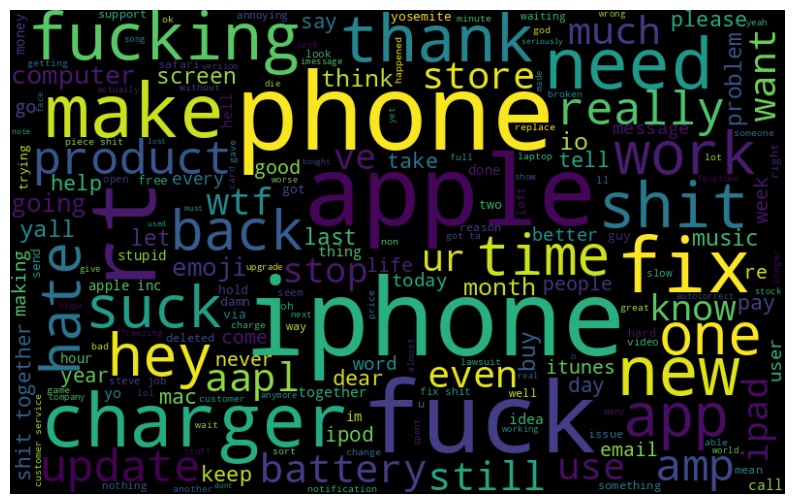

In [18]:
#Common words for the negative sentiments
#Negative words
negative_words = ' '.join(data.query("sentiment==1")['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In this part we create a FreqDist class Keeping the 20 most common words for negative sentiments

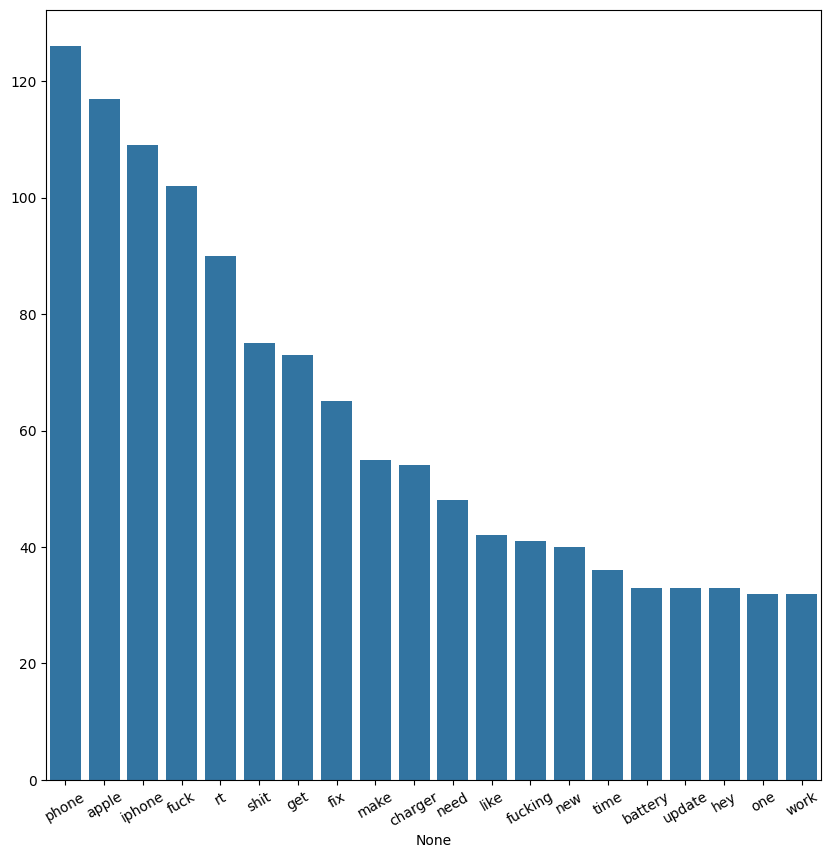

In [19]:
negative_tokens = word_tokenize(negative_words) #tokenize data
all_fdist = FreqDist(negative_tokens).most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

The visualization below shows the most frequent words in the positive sentiment.

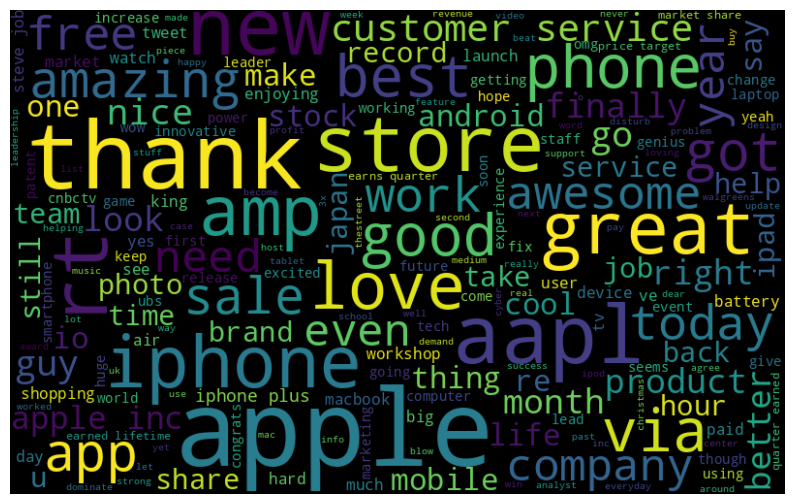

In [20]:
#positive words
positive_words = ' '.join(data.query('sentiment==5')['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21 ,max_font_size=110).generate(positive_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off');

The Freqdist class shows the most common 20 words for positive sentiments

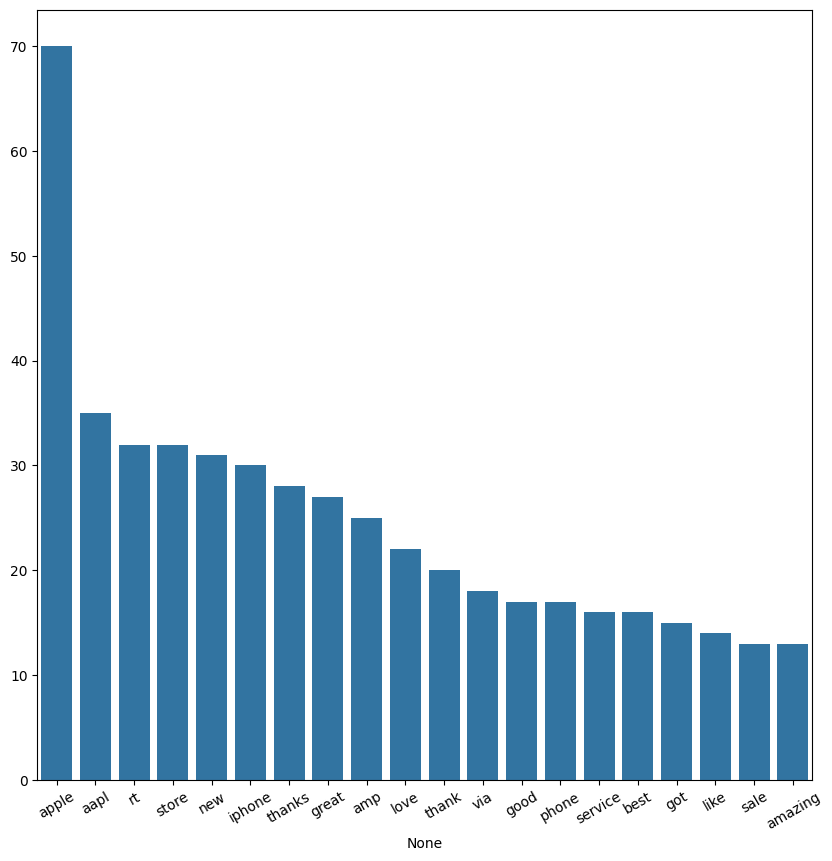

In [21]:
positive_tokens = word_tokenize(positive_words) #tokenize data
all_fdist = FreqDist(positive_tokens).most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

###The visualization below shows the most frequent words in the neutral sentiment.

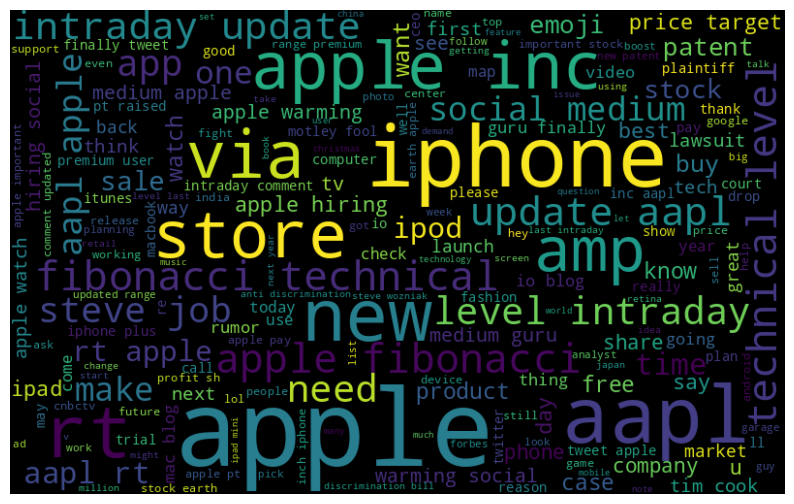

In [22]:
#Common words for neutral words
neutral_words = ' '.join(data.query('sentiment==3')['cleaned_text'])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21 ,max_font_size=110).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()



We use Freqdist class to show most common 20 words for Neutral sentiments

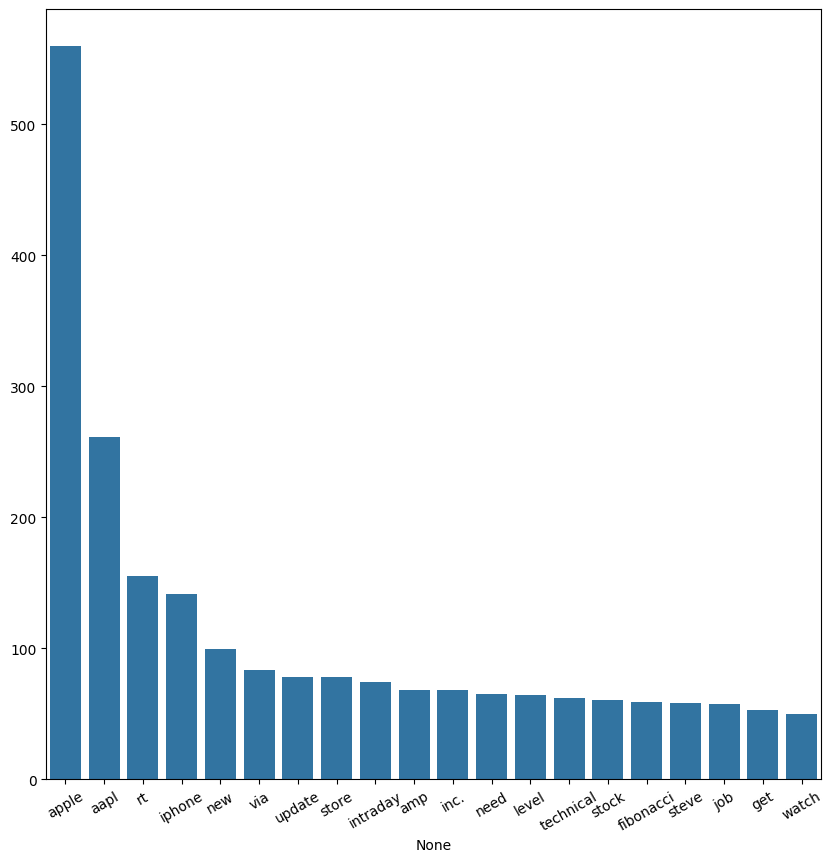

In [23]:
neutral_tokens = word_tokenize(neutral_words) #tokenize data
all_fdist = FreqDist(neutral_tokens).most_common(20)

#Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

#Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

#Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);


#4. Modelling

We will conduct a train_test split for modelling then use pipelines to streamline vectorization, smote and modelling process.

We then evaluate the models using accuray_score,precision,recall,f1 score and roc_auc

In [24]:
#Split data into x and y and perform a train,test split of the dataset
X = data['cleaned_text']

# Convert y labels to start from 0
y = data['sentiment'].map({1: 0, 3: 1, 5: 2})  # Mapping 1 → 0, 3 → 1, 5 → 2

# Split data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)


In [25]:
#Creating a pipeline to streamline vectorization and for modelling
 #(Starting with the base model using logistic regression)
pipeline = Pipeline([
    ('tdif',TfidfVectorizer(ngram_range=(1,2))),
    ('smote',SMOTE()),
    ('model',LogisticRegression())
])


Function to train the model ,make predictions and calculate evaluation metrics

In [62]:
#Function to train the model ,make predictions and calculate evaluation metrics
def modelling(pipe):
    pipe.fit(X_train, y_train)

    # Predict train and test data
    y_hat_train = pipe.predict(X_train)
    y_hat_test = pipe.predict(X_test)

    # Get accuracy, precision, recall, and F1-score
    base_train_accuracy = accuracy_score(y_train, y_hat_train)
    base_test_accuracy = accuracy_score(y_test, y_hat_test)
    base_train_precision = precision_score(y_train, y_hat_train, average='weighted')
    base_test_precision = precision_score(y_test, y_hat_test, average='weighted')
    base_train_recall = recall_score(y_train, y_hat_train, average='weighted')
    base_test_recall = recall_score(y_test, y_hat_test, average='weighted')
    base_train_f1 = f1_score(y_train, y_hat_train, average='weighted')
    base_test_f1 = f1_score(y_test, y_hat_test, average='weighted')

    # Binarize labels for multiclass ROC curve
    classes = sorted(set(y_train))  # Get unique classes
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Get prediction scores
    if hasattr(pipe, "decision_function"):
        y_score_train = pipe.decision_function(X_train)
        y_score_test = pipe.decision_function(X_test)
    else:
        y_score_train = pipe.predict_proba(X_train)
        y_score_test = pipe.predict_proba(X_test)

    # Compute ROC curve and AUC for each class
    train_auc_list, test_auc_list = [], []
    plt.figure(figsize=(8, 6))

    for i in range(len(classes)):
        train_fpr, train_tpr, _ = roc_curve(y_train_bin[:, i], y_score_train[:, i])
        test_fpr, test_tpr, _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])

        train_auc = auc(train_fpr, train_tpr)
        test_auc = auc(test_fpr, test_tpr)

        train_auc_list.append(train_auc)
        test_auc_list.append(test_auc)

        sns.lineplot(x=test_fpr, y=test_tpr, label=f'Class {classes[i]} - Test AUC: {test_auc:.4f}')

    # Average AUC
    avg_train_auc = sum(train_auc_list) / len(train_auc_list)
    avg_test_auc = sum(test_auc_list) / len(test_auc_list)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend()
    plt.show()

    return {
        'Training Accuracy': base_train_accuracy,
        'Test Accuracy': base_test_accuracy,
#         'Training precision': base_train_precision,
        'Test precision': base_test_precision,
#         'Training recall': base_train_recall,
        'Test recall': base_test_recall,
#         'Training f1_score': base_train_f1,
        'Test f1_score': base_test_f1,
        'Average Train AUC': avg_train_auc,
        'Average Test AUC': avg_test_auc
    }

#Model Evaluation

In the model evaluation, we have used different types of machine learning models such as Logistic Regression, Random Forest, Multinomial Naive Bayes, Decision Trees, Support Vector Machines and XGboost.

We evaluated the model performance using the ROC/AUC curve.

A perfect model has an AUC of 1.0.

Logistic Regression Evaluation

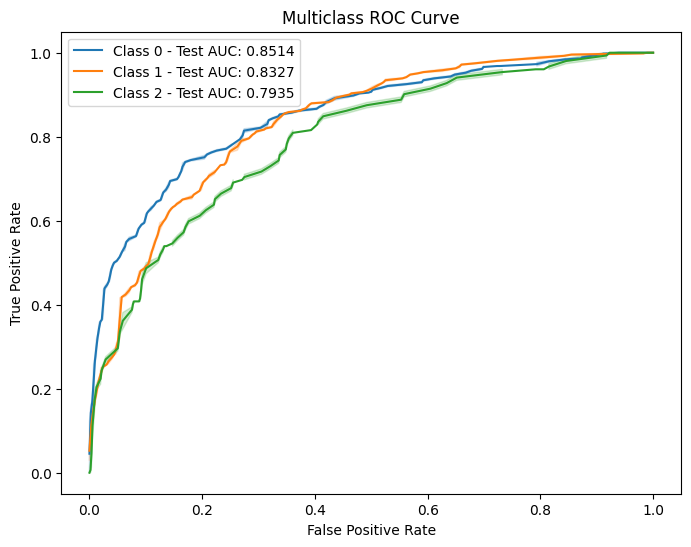

{'Training Accuracy': 0.963226571767497,
 'Test Accuracy': 0.6998420221169036,
 'Test precision': 0.6959966942244212,
 'Test recall': 0.6998420221169036,
 'Test f1_score': 0.6977203565861783,
 'Average Train AUC': np.float64(0.9926244408497641),
 'Average Test AUC': np.float64(0.8258608441410296)}

In [27]:
logreg = modelling(pipeline)
logreg

Random Forest(using set_params to change pipeline from Logistic Regression to Random Forest)

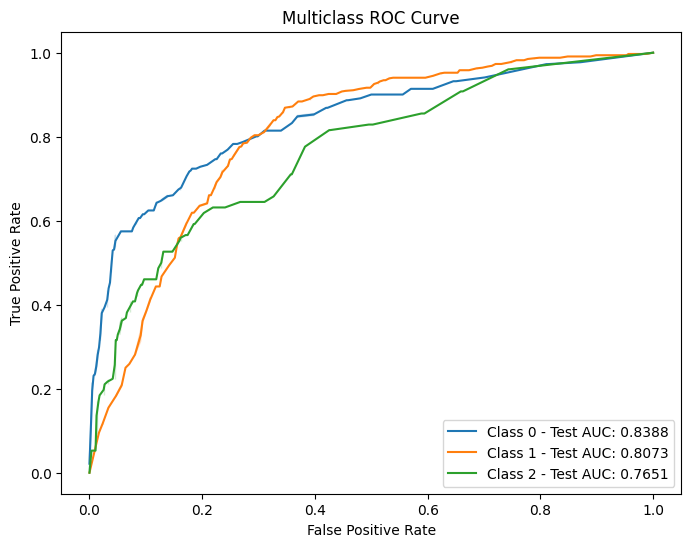

{'Training Accuracy': 0.9905100830367735,
 'Test Accuracy': 0.6951026856240127,
 'Test precision': 0.7059677715138306,
 'Test recall': 0.6951026856240127,
 'Test f1_score': 0.6699047345492842,
 'Average Train AUC': np.float64(0.9994969726961748),
 'Average Test AUC': np.float64(0.803696877887203)}

In [28]:
pipeline.set_params(model=RandomForestClassifier(random_state=42))
rdf = modelling(pipeline)
rdf

Multinomial naive bayes

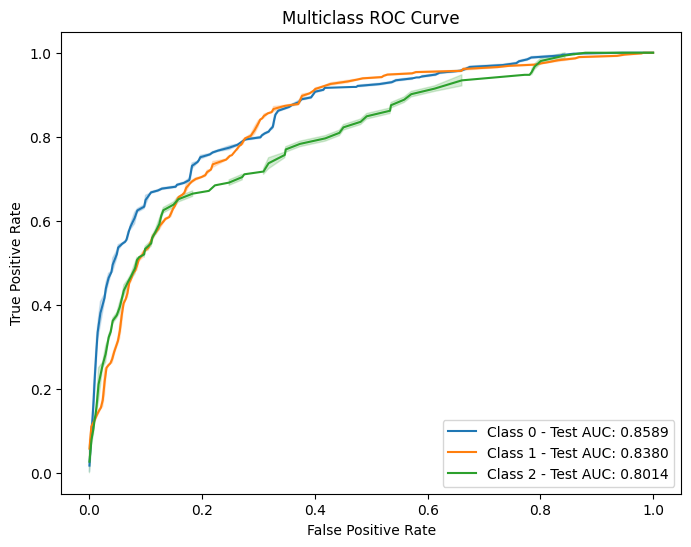

{'Training Accuracy': 0.9402926057730329,
 'Test Accuracy': 0.688783570300158,
 'Test precision': 0.7146545720158317,
 'Test recall': 0.688783570300158,
 'Test f1_score': 0.6957875105511914,
 'Average Train AUC': np.float64(0.9882804530062135),
 'Average Test AUC': np.float64(0.8327487912443635)}

In [29]:
pipeline.set_params(model = MultinomialNB())
nb =  modelling(pipeline)
nb

Decision Tree

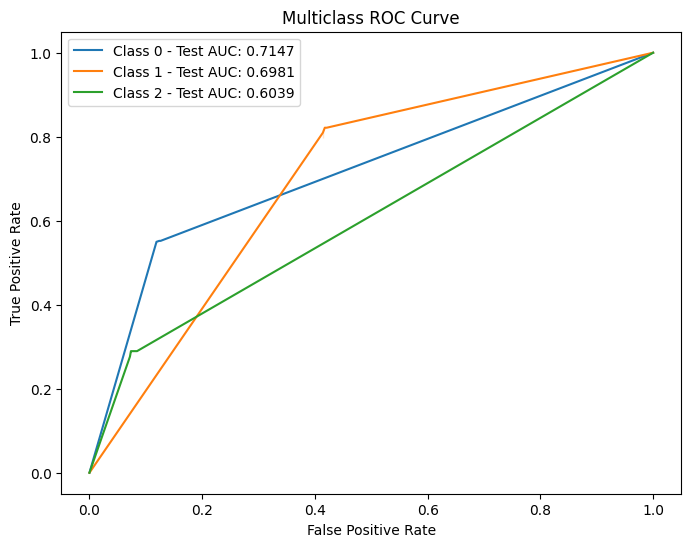

{'Training Accuracy': 0.9905100830367735,
 'Test Accuracy': 0.660347551342812,
 'Test precision': 0.6533848227129692,
 'Test recall': 0.660347551342812,
 'Test f1_score': 0.6502224102116915,
 'Average Train AUC': np.float64(0.999876025147195),
 'Average Test AUC': np.float64(0.6722134514155497)}

In [30]:
pipeline.set_params(model = DecisionTreeClassifier(random_state=42))
dt = modelling(pipeline)
dt

 Support Vector Machines

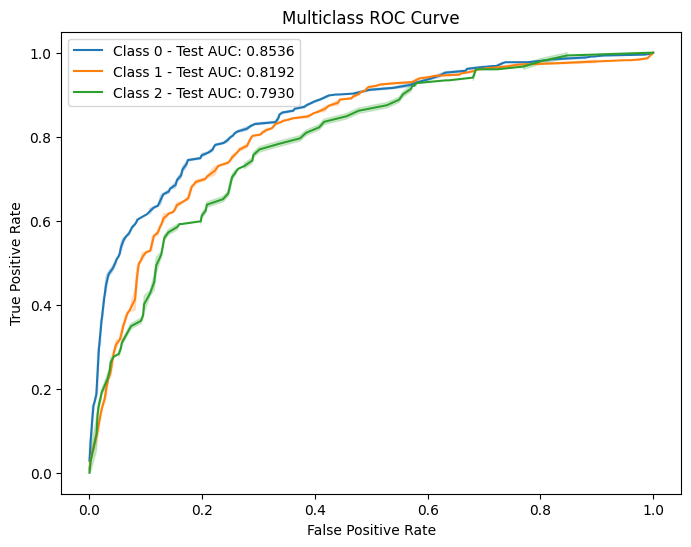

{'Training Accuracy': 0.9790431000395413,
 'Test Accuracy': 0.7061611374407583,
 'Test precision': 0.6966408188909469,
 'Test recall': 0.7061611374407583,
 'Test f1_score': 0.6852949882066476,
 'Average Train AUC': np.float64(0.9958388188741658),
 'Average Test AUC': np.float64(0.8219379286844178)}

In [31]:
from sklearn.svm import SVC # Import the SVC class directly
pipeline.set_params(model=SVC()) # Use SVC() to instantiate the model
svm = modelling(pipeline)
svm

XGBoost

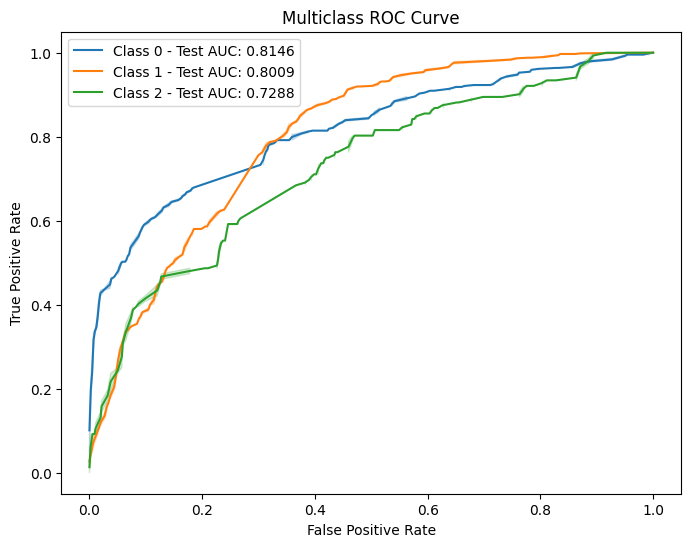

{'Training Accuracy': 0.8884934756820878,
 'Test Accuracy': 0.6919431279620853,
 'Test precision': 0.6967957939789139,
 'Test recall': 0.6919431279620853,
 'Test f1_score': 0.6701998270144212,
 'Average Train AUC': np.float64(0.9738078878216744),
 'Average Test AUC': np.float64(0.7814534510148269)}

In [32]:
pipeline.set_params(model = XGBClassifier())
xgb = modelling(pipeline)
xgb

Storing the Model results into a dataframe

In [33]:
# Dictionary of model results
model_results = {
    "Logistic Regression": logreg,
    "Random Forest": rdf,
    "Naïve Bayes":nb,
    "Decision Tree": dt,
    "SVM": svm,
    "XGBoost": xgb,
}

# Convert dictionary to DataFrame
df_results = pd.DataFrame.from_dict(model_results, orient='index')

# Display the DataFrame
df_results

,Training Accuracy,Test Accuracy,Test precision,Test recall,Test f1_score,Average Train AUC,Average Test AUC
Logistic Regression,0.963227,0.699842,0.695997,0.699842,0.697720,0.992624,0.825861
Random Forest,0.990510,0.695103,0.705968,0.695103,0.669905,0.999497,0.803697
Naïve Bayes,0.940293,0.688784,0.714655,0.688784,0.695788,0.988280,0.832749
Decision Tree,0.990510,0.660348,0.653385,0.660348,0.650222,0.999876,0.672213
SVM,0.979043,0.706161,0.696641,0.706161,0.685295,0.995839,0.821938
XGBoost,0.888493,0.691943,0.696796,0.691943,0.670200,0.973808,0.781453


Checking the Difference between train and test accuracy

In [34]:
df_results['Training Accuracy'] - df_results['Test Accuracy']

,0
Logistic Regression,0.263385
Random Forest,0.295407
Naïve Bayes,0.251509
Decision Tree,0.330163
SVM,0.272882
XGBoost,0.196550


From the models tested we see varying degrees of overfitting and generalization ability across different models.Decision trees and random Forest performance might fail in real word due to overfitting

Higher AUC is seen in the models indicating models performs well in separating the classes
XGBoost has the best generalization as it has the smallest gap between the train and test accuracy

On simple models logistic regression performs well with a good balance between precision and recall

Defining parameter grid

In [35]:
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [ 0.1, 0.2,0.4],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2]
}

Find the best parameters using RandomSearchCV

In [36]:
from sklearn.model_selection import RandomizedSearchCV

# Optimized RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,  # Uses random sampling of hyperparameters
    scoring='accuracy',
    n_iter=15,  # Adjust to control search time (lower for faster results)
    cv=3,  # Reduce cross-validation folds for speed
    verbose=1,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best hyperparameters
random_search.best_params_




Fitting 3 folds for each of 15 candidates, totalling 45 fits


{'model__subsample': 1.0,
 'model__n_estimators': 100,
 'model__max_depth': 7,
 'model__learning_rate': 0.1,
 'model__gamma': 0.1,
 'model__colsample_bytree': 0.8}

Lets retrain the model with the best parameters

In [37]:
pipeline.set_params(model=XGBClassifier(
                            learning_rate= 0.2,
                            max_depth= 3,
                            n_estimators= 500,
                            colsample_bytree =  0.7,
                            subsample = 1.0
))

Pipeline(steps=[('tdif', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Evaluate the model with the best parameters

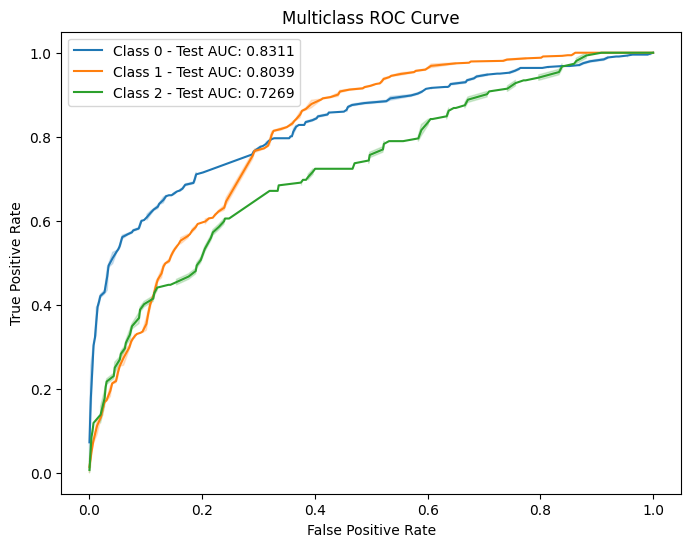

{'Training Accuracy': 0.9141953341241598,
 'Test Accuracy': 0.6998420221169036,
 'Test precision': 0.7030734748498874,
 'Test recall': 0.6998420221169036,
 'Test f1_score': 0.6830005290389551,
 'Average Train AUC': np.float64(0.9846347334266904),
 'Average Test AUC': np.float64(0.787320230606599)}

In [38]:
xgb_tuned = modelling(pipeline)
xgb_tuned

In [39]:
#Comparing the results without the tuning
df_results

,Training Accuracy,Test Accuracy,Test precision,Test recall,Test f1_score,Average Train AUC,Average Test AUC
Logistic Regression,0.963227,0.699842,0.695997,0.699842,0.697720,0.992624,0.825861
Random Forest,0.990510,0.695103,0.705968,0.695103,0.669905,0.999497,0.803697
Naïve Bayes,0.940293,0.688784,0.714655,0.688784,0.695788,0.988280,0.832749
Decision Tree,0.990510,0.660348,0.653385,0.660348,0.650222,0.999876,0.672213
SVM,0.979043,0.706161,0.696641,0.706161,0.685295,0.995839,0.821938
XGBoost,0.888493,0.691943,0.696796,0.691943,0.670200,0.973808,0.781453


No major improvement in accuracy — The test accuracy and F1 score increased by 1% or less
AUC improved slightly —
The Test AUC actually increased by just 0.0004
Tuning reduced slight overfitting — meaning the model is generalizing slightly better.

Tuning Logistic Regression

In [40]:
pipeline.set_params(model = LogisticRegression())
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'model__penalty': ['l1', 'l2'],  # Type of regularization
    'model__solver': ['liblinear']  # Required for L1 penalty
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best accuracy Score:", grid.best_score_)

Best Parameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best accuracy Score: 0.7014714514929754


Use this parameters for our model

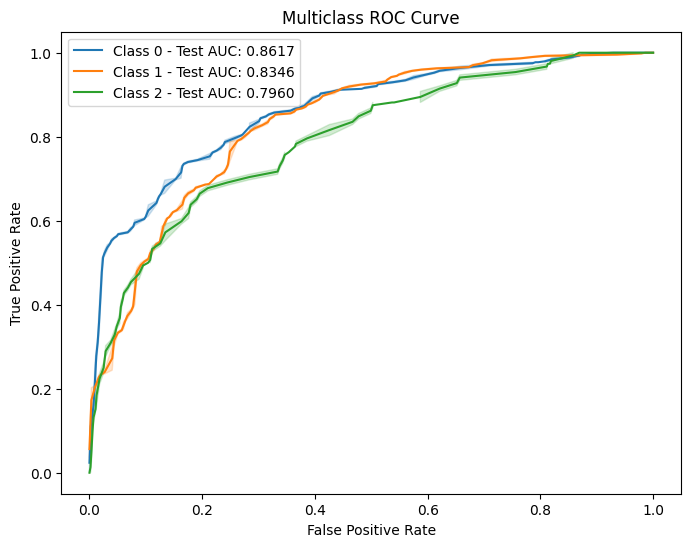

{'Training Accuracy': 0.9829972321075524,
 'Test Accuracy': 0.7203791469194313,
 'Test precision': 0.7162286386413856,
 'Test recall': 0.7203791469194313,
 'Test f1_score': 0.7179443471976618,
 'Average Train AUC': np.float64(0.9985208212107063),
 'Average Test AUC': np.float64(0.83079687526255)}

In [41]:
pipeline.set_params(model = LogisticRegression(
                                              C= 10,
                                             penalty = 'l2',
                                             solver = 'liblinear'
))
logistic_tuned= modelling(pipeline)
logistic_tuned

There is an increase by 2% in accuracy, precision, recall and F1 score.
lets compare XG Boost and logistic regression

In [42]:
model_results = {
    "Logistic Regression_tuned": logistic_tuned,
    "XGBoost_tuned": xgb_tuned,
}

# Convert dictionary to DataFrame
df_results_tuned = pd.DataFrame.from_dict(model_results, orient='index')

# Display the DataFrame
df_results_tuned

,Training Accuracy,Test Accuracy,Test precision,Test recall,Test f1_score,Average Train AUC,Average Test AUC
Logistic Regression_tuned,0.982997,0.720379,0.716229,0.720379,0.717944,0.998521,0.830797
XGBoost_tuned,0.914195,0.699842,0.703073,0.699842,0.683001,0.984635,0.787320


Logistic regression performs much better than XG Boost.We will use logistic regression model to make our predictions

LOGISTIC REGRESSION MODEL WAS USED TO MAKE OUR PREDICTIONS

 Making predictions

In [43]:
#create function to predict sentiment
pipeline.set_params(model =  LogisticRegression(
                                              C= 10,
                                             penalty = 'l2',
                                             solver = 'liblinear'))
pipeline.fit(X_train,y_train)
def sentiment_check(tweet):
    tweet_processed = clean_text(tweet)
    print(f'tweet:{tweet_processed}')
    prediction = pipeline.predict([tweet_processed])[0]
    if prediction == 0:
        return('Negative statement')
    elif prediction == 1:
        return('Neutral statement')
    else:
        return('Positive statement')


In [44]:
print(sentiment_check('I bought a new phone and its so good'))

tweet:bought new phone good
Positive statement


In [45]:
print(sentiment_check('I hate that new phone and its not good' ))

tweet:hate new phone good
Negative statement


In [46]:
print(sentiment_check('I will get you a new phone'))

tweet:get new phone
Positive statement


In [47]:
print(sentiment_check('I will get a phone'))

tweet:get phone
Negative statement


In [48]:
print(sentiment_check('phone get will'))

tweet:phone get
Negative statement


In [49]:
print(sentiment_check('I got a phone'))

tweet:got phone
Negative statement


In [50]:
print(sentiment_check('phone'))

tweet:phone
Negative statement


In [51]:
print(sentiment_check('level'))

tweet:level
Neutral statement


#Conclusions and recommendations
Conclusion
- Logistic Regression outperformed XGBoost, achieving better accuracy and F1 score, making it the preferred model for sentiment classification.
- Hyperparameter tuning for XGBoost led to only marginal improvements (accuracy & F1 score increased by ≤1%, AUC by 0.0004).
- Tuning helped reduce overfitting slightly, meaning XGBoost generalized better than before, but still did not surpass Logistic Regression.

Recommendations
- Use Logistic Regression for final predictions since it performs better than XGBoost.
- Consider feature engineering (e.g., word embeddings like Word2Vec or BERT) to improve model performance further.
- Explore deep learning models (e.g., LSTMs or Transformers) if higher accuracy is required.
- Continue tuning XGBoost or test alternative ensemble methods if needed for comparison.
